In [1]:
import torch
from torch import nn
import numpy as np
import sys
import os
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import importlib
import h5py

sys.path.append("..")
from model import ParticleEventTransformer
from data import get_database_path, get_h5_files, read_h5_file, select_events
from utils import load_toml_config
from analysis import Normalizer
from classify import train_model

import matplotlib.pyplot as plt

import importlib
import classify
import analysis
importlib.reload(classify)
importlib.reload(analysis)
from classify import train_model
from analysis import Bootstrap_Permutation
opt_train_model  = torch.compile(train_model)
from analysis import LambdaEstimator
from metrics import BinaryACCUpdater
from analysis import create_exp_bkg_events, train_test_split, get_dataloaders
from model import MLP

device = "cuda" if torch.cuda.is_available() else "mps" if sys.platform == "darwin" else "cpu"
random_seed = 114514
torch.manual_seed(random_seed)
np.random.seed(random_seed)

In [2]:
database_path = "/home/desmondhe/ADwithNE/latent"
output_dim = [2,4,8,16,32]
embedding_points_file_name = {}
embedding_points_file = {}
embedding_points = {}
targets = {}
for dim in output_dim:
    embedding_points_file_name[dim] = "embedding_points_dim{}.h5".format(dim)
    embedding_points_file[dim] = os.path.join(database_path, embedding_points_file_name[dim])
    embedding_points[dim] = h5py.File(embedding_points_file[dim])
bsm_events = ['charged_Higgs', 'leptoquark', 'neutral_Higgs', 'neutral_boson']
# Load bkg labels
bkg_id = np.load('../data/background_IDs_-1.npz')
set_labels = ['background_ID_train', 'background_ID_test', 'background_ID_val']
bkg_labels = np.concatenate([bkg_id[label] for label in set_labels], axis=0)

assert embedding_points[2]['SM'].shape[0] == len(bkg_labels)

In [ ]:
tpr_dict = {}
fpr_dict = {}
auc_dict = {}


In [5]:
test_ratio=0.2
val_ratio = 0.2
sig_lambda = 0.5
n = 200000

# test_signal = "neutral_boson"
# test_signal = "leptoquark"
test_signal = "neutral_Higgs"
test_dimension = 16
# test_signal = "charged_Higgs"

normalizer = Normalizer(*[value for value in embedding_points[test_dimension].values()])

exp_events, bkg_events = create_exp_bkg_events(np.array(embedding_points[test_dimension]['SM']), np.array(embedding_points[test_dimension][test_signal]), sig_lambda, n)
X1, X2, W1, W2 = train_test_split(exp_events, bkg_events, test_ratio)
n1 = len(W1)
m1 = len(X1)
pi = n1 / (n1 + m1)
n2 = len(W2)
m2 = len(X2)
train_dataloader, val_dataloader = get_dataloaders(X1, W1, val_ratio, normalizer)

# Classify Model

In [ ]:

hidden_dim = [8, 16, 16, 16, 8]
naive_model = MLP(test_dimension, hidden_sizes=hidden_dim)

In [7]:
naive_model.to(device)
optimizer = torch.optim.Adam(naive_model.parameters(), lr=1e-3, weight_decay=1e-5)
loss_fn = nn.BCELoss()
acc_metric = BinaryACCUpdater()
metric_dict = {"Accuracy": acc_metric}

In [14]:
train_model(
    naive_model, optimizer,
    loss_fn, metrics_dict=metric_dict,
    train_dataloader=train_dataloader, val_dataloader=val_dataloader,
    monitor="val_Accuracy", mode="max",
    epochs=50
    )


================================================================================2024-11-27 16:07:30
Epoch 1 / 50

100%|██████████| 250/250 [00:00<00:00, 852.87it/s, val_Accuracy=0.5, val_loss=0.693]
<<<<<< reach best val_Accuracy : 0.5 >>>>>>

================================================================================2024-11-27 16:07:38
Epoch 2 / 50

100%|██████████| 250/250 [00:00<00:00, 882.96it/s, val_Accuracy=0.5, val_loss=0.693]

================================================================================2024-11-27 16:07:46
Epoch 3 / 50

100%|██████████| 250/250 [00:00<00:00, 839.96it/s, val_Accuracy=0.5, val_loss=0.693]

================================================================================2024-11-27 16:07:54
Epoch 4 / 50

100%|██████████| 250/250 [00:00<00:00, 885.95it/s, val_Accuracy=0.5, val_loss=0.693]

================================================================================2024-11-27 16:08:03
Epoch 5 / 50

100%|██████████| 250/250 [00:00<00:00, 88

,train_loss,train_Accuracy,val_loss,val_Accuracy,epoch
0,0.693192,0.500160,0.693148,0.5,1
1,0.693168,0.500148,0.693148,0.5,2
2,0.693164,0.500656,0.693149,0.5,3
3,0.693168,0.499000,0.693158,0.5,4
4,0.693166,0.500133,0.693162,0.5,5
5,0.693160,0.501250,0.693147,0.5,6


In [14]:
lambda_mean_dict = {}
lambda_std_dict = {}

lrt_p_permutation_dict = {}
lrt_p_bootstrap_dict = {}
auc_p_permutation_dict = {}
auc_p_bootstrap_dict = {}
mce_p_permutation_dict = {}
mce_p_bootstrap_dict = {}

lrt_p_dict = {}
auc_p_dict = {}
mce_p_dict = {}

In [16]:
threshold_dict = load_toml_config("threshold")
print(threshold_dict)

{'lrt': 0.014815863868755264, 'mce': 0.49852925000000003, 'auc': 0.50212982325}


In [9]:
n_bootstrap = 10


test_ratio=0.2
val_ratio = 0.2
n = 200000
n_null = 1000

test_signal = "neutral_boson"
# test_signal = "leptoquark"
# test_signal = "neutral_Higgs"
# test_signal = "charged_Higgs"
significance = 0.05


test_lambdas = [0.005, 0.01, 0.02, 0.05, 0.1]
test_dimension = 16

for i in tqdm(range(len(test_lambdas)), position=0, leave=True):
    sig_lambda = test_lambdas[i]

    estimated_lambdas = np.zeros(n_bootstrap)

    lrt_permutation_power = 0
    lrt_bootstrap_power = 0
    auc_permutation_power = 0
    auc_bootstrap_power = 0
    mce_permutation_power = 0
    mce_bootstrap_power = 0

    lrt_power =0 
    auc_power = 0
    mce_power = 0
    for j in tqdm(range(n_bootstrap), position=1, leave=False):
        exp_events, bkg_events = create_exp_bkg_events(np.array(embedding_points[test_dimension]['SM']), np.array(embedding_points[test_dimension][test_signal]), sig_lambda, n)
        X1, X2, W1, W2 = train_test_split(exp_events, bkg_events, test_ratio)
        n1 = len(W1)
        m1 = len(X1)
        n2 = len(W2)
        m2 = len(X2)
        train_dataloader, val_dataloader = get_dataloaders(X1, W1, val_ratio, normalizer)

        hidden_dim = [8, 16, 16, 16, 8]
        naive_model = MLP(test_dimension, hidden_sizes=hidden_dim)
        naive_model.to(device)
        optimizer = torch.optim.Adam(naive_model.parameters(), lr=1e-3, weight_decay=1e-5)
        loss_fn = nn.BCELoss()
        acc_metric = BinaryACCUpdater()
        metric_dict = {"Accuracy": acc_metric}

        train_model(
            naive_model, optimizer,
            loss_fn, metrics_dict=metric_dict,
            train_dataloader=train_dataloader, val_dataloader=val_dataloader,
            monitor="val_Accuracy", mode="max",
            epochs=50,
            verbose=False
            )
        
        bootstrap_permutation = Bootstrap_Permutation(X2, W2, naive_model, pi, normalizer)
        _, _, _ = bootstrap_permutation.bootstrap(n_null, verbose=False)
        _, _, _ = bootstrap_permutation.permutation(n_null, verbose=False)
        if bootstrap_permutation.lrt_p_permutation < significance:
            print(bootstrap_permutation.lrt_p_permutation)
            lrt_permutation_power += 1
        if bootstrap_permutation.lrt_p_bootstrap < significance:
            print(bootstrap_permutation.lrt_p_bootstrap)
            lrt_bootstrap_power += 1
        if bootstrap_permutation.auc_p_permutation < significance:
            print(bootstrap_permutation.auc_p_permutation)
            auc_permutation_power += 1
        if bootstrap_permutation.auc_p_bootstrap < significance:
            print(bootstrap_permutation.auc_p_bootstrap)
            auc_bootstrap_power += 1
        if bootstrap_permutation.mce_p_permutation < significance:
            print(bootstrap_permutation.mce_p_permutation)
            mce_permutation_power += 1
        if bootstrap_permutation.mce_p_bootstrap < significance:
            print(bootstrap_permutation.mce_p_bootstrap)
            mce_bootstrap_power += 1

        if bootstrap_permutation.lrt_exp > threshold_dict["lrt"]:
            lrt_power += 1

        if bootstrap_permutation.mce_exp < threshold_dict["mce"]:
            mce_power += 1

        if bootstrap_permutation.auc_exp > threshold_dict["auc"]:
            auc_power += 1

        lambda_estimator = LambdaEstimator(X2, W2, naive_model, T=0.5, n_bins=20, normalizer=normalizer)
        estimated_lambdas[j] = lambda_estimator.estimated_lambda
    print("sig_lambda:", sig_lambda, "estimated lambda mean:", estimated_lambdas.mean(), "estimated lambda std:", estimated_lambdas.std())
    lambda_mean_dict[str(sig_lambda)] = estimated_lambdas.mean()
    lambda_std_dict[str(sig_lambda)] = estimated_lambdas.std(ddof = 1)

    lrt_p_permutation_dict[str(sig_lambda)] = lrt_permutation_power
    lrt_p_bootstrap_dict[str(sig_lambda)] = lrt_bootstrap_power
    auc_p_permutation_dict[str(sig_lambda)] = auc_permutation_power
    auc_p_bootstrap_dict[str(sig_lambda)] = auc_bootstrap_power
    mce_p_permutation_dict[str(sig_lambda)] = mce_permutation_power
    mce_p_bootstrap_dict[str(sig_lambda)] = mce_bootstrap_power

    lrt_p_dict[str(sig_lambda)] = lrt_power
    auc_p_dict[str(sig_lambda)] = auc_power
    mce_p_dict[str(sig_lambda)] = mce_power

  0%|          | 0/5 [00:02<?, ?it/s]


NameError: name 'BinaryACCUpdater' is not defined

In [3]:
n_bootstrap = 5
# p_value_method = 'count'
p_value_method = 'fit'

test_ratio=0.2
val_ratio = 0.2
n = 200000
n_null = 1000

# test_signal = "neutral_boson"
# test_signal = "leptoquark"
# test_signal = "neutral_Higgs"
test_signal = "charged_Higgs"
significance = 0.05

database_path = "/home/desmondhe/ADwithNE/latent"
output_dim = [2,4,8,16,32]
# output_dim = [2,4]
test_lambdas = [0.005, 0.01, 0.02, 0.05, 0.1]

lrt_permuation_p_value_mean = np.zeros((len(output_dim), len(test_lambdas)))
lrt_permuation_p_value_std = np.zeros((len(output_dim), len(test_lambdas)))
lrt_bootstrap_p_value_mean = np.zeros((len(output_dim), len(test_lambdas)))
lrt_bootstrap_p_value_std = np.zeros((len(output_dim), len(test_lambdas)))
                                     
auc_permuation_p_value_mean = np.zeros((len(output_dim), len(test_lambdas)))
auc_permuation_p_value_std = np.zeros((len(output_dim), len(test_lambdas)))
auc_bootstrap_p_value_mean = np.zeros((len(output_dim), len(test_lambdas)))
auc_bootstrap_p_value_std = np.zeros((len(output_dim), len(test_lambdas)))
                                     
mce_permuation_p_value_mean = np.zeros((len(output_dim), len(test_lambdas)))
mce_permuation_p_value_std = np.zeros((len(output_dim), len(test_lambdas)))
mce_bootstrap_p_value_mean = np.zeros((len(output_dim), len(test_lambdas)))
mce_bootstrap_p_value_std = np.zeros((len(output_dim), len(test_lambdas)))

lambda_mean = np.zeros((len(output_dim), len(test_lambdas)))
lambda_std = np.zeros((len(output_dim), len(test_lambdas)))
for a, test_dimension in enumerate(output_dim):
    normalizer = Normalizer(*[value for value in embedding_points[test_dimension].values()])
    for i in tqdm(range(len(test_lambdas)), position=0, leave=True):
        sig_lambda = test_lambdas[i]

        estimated_lambdas = np.zeros(n_bootstrap)
        lrt_permutation_p_values = np.zeros(n_bootstrap)
        lrt_bootstrap_p_values = np.zeros(n_bootstrap)
        auc_permutation_p_values = np.zeros(n_bootstrap)
        auc_bootstrap_p_values = np.zeros(n_bootstrap)
        mce_permutation_p_values = np.zeros(n_bootstrap)
        mce_bootstrap_p_values = np.zeros(n_bootstrap)
        
        for j in tqdm(range(n_bootstrap), position=1, leave=False):
            exp_events, bkg_events = create_exp_bkg_events(np.array(embedding_points[test_dimension]['SM']), np.array(embedding_points[test_dimension][test_signal]), sig_lambda, n)
            X1, X2, W1, W2 = train_test_split(exp_events, bkg_events, test_ratio)
            n1 = len(W1)
            m1 = len(X1)
            n2 = len(W2)
            m2 = len(X2)
            pi = n1 / (n1 + m1)
            train_dataloader, val_dataloader = get_dataloaders(X1, W1, val_ratio, normalizer)

            hidden_dim = [8, 16, 16, 16, 8]
            naive_model = MLP(test_dimension, hidden_sizes=hidden_dim)
            naive_model.to(device)
            optimizer = torch.optim.Adam(naive_model.parameters(), lr=1e-3, weight_decay=1e-5)
            loss_fn = nn.BCELoss()
            acc_metric = BinaryACCUpdater()
            metric_dict = {"Accuracy": acc_metric}

            train_model(
                naive_model, optimizer,
                loss_fn, metrics_dict=metric_dict,
                train_dataloader=train_dataloader, val_dataloader=val_dataloader,
                monitor="val_Accuracy", mode="max",
                epochs=50,
                verbose=False
                )
            
            bootstrap_permutation = Bootstrap_Permutation(X2, W2, naive_model, pi, normalizer)
            _, _, _ = bootstrap_permutation.bootstrap(n_null, verbose=False, n_jobs=64, method=p_value_method)
            _, _, _ = bootstrap_permutation.permutation(n_null, verbose=False, n_jobs=64, method=p_value_method)

            lrt_permutation_p_values[j] = bootstrap_permutation.lrt_p_permutation
            lrt_bootstrap_p_values[j] = bootstrap_permutation.lrt_p_bootstrap
            auc_permutation_p_values[j] = bootstrap_permutation.auc_p_permutation
            auc_bootstrap_p_values[j] = bootstrap_permutation.auc_p_bootstrap
            mce_permutation_p_values[j] = bootstrap_permutation.mce_p_permutation
            mce_bootstrap_p_values[j] = bootstrap_permutation.mce_p_bootstrap



            # lambda_estimator = LambdaEstimator(X2, W2, naive_model, T=0.5, n_bins=20, normalizer=normalizer)
            # estimated_lambdas[j] = lambda_estimator.estimated_lambda
        # print("sig_lambda:", sig_lambda, "estimated lambda mean:", estimated_lambdas.mean(), "estimated lambda std:", estimated_lambdas.std())
        # lambda_mean[a][i] = estimated_lambdas.mean()
        # lambda_std[a][i] = estimated_lambdas.std(ddof = 1)

        lrt_permuation_p_value_mean[a][i] = np.mean(lrt_permutation_p_values)
        lrt_permuation_p_value_std[a][i] = np.var(lrt_permutation_p_values, ddof=1)
        lrt_bootstrap_p_value_mean[a][i] = np.mean(lrt_bootstrap_p_values)
        lrt_bootstrap_p_value_std[a][i] = np.var(lrt_bootstrap_p_values, ddof=1)

        auc_permuation_p_value_mean[a][i] = np.mean(auc_permutation_p_values)
        auc_permuation_p_value_std[a][i] = np.var(auc_permutation_p_values, ddof=1)
        auc_bootstrap_p_value_mean[a][i] = np.mean(auc_bootstrap_p_values)
        auc_bootstrap_p_value_std[a][i] = np.var(auc_bootstrap_p_values, ddof=1)

        mce_permuation_p_value_mean[a][i] = np.mean(mce_permutation_p_values)
        mce_permuation_p_value_std[a][i] = np.var(mce_permutation_p_values, ddof=1)
        mce_bootstrap_p_value_mean[a][i] = np.mean(mce_bootstrap_p_values)
        mce_bootstrap_p_value_std[a][i] = np.var(mce_bootstrap_p_values, ddof=1)


  0%|          | 0/5 [00:00<?, ?it/s]

: 

In [8]:
np.savez('../paper/Kuusela_'+test_signal+'_'+p_value_method+'.npz', 
        lrt_bootstrap_p_value_mean=lrt_bootstrap_p_value_mean,
        lrt_bootstrap_p_value_std=lrt_bootstrap_p_value_std,
        lrt_permuation_p_value_mean=lrt_permuation_p_value_mean,
        lrt_permuation_p_value_std=lrt_permuation_p_value_std,
        auc_bootstrap_p_value_mean=auc_bootstrap_p_value_mean,
        auc_bootstrap_p_value_std=auc_bootstrap_p_value_std,
        auc_permuation_p_value_mean=auc_permuation_p_value_mean,
        auc_permuation_p_value_std=auc_permuation_p_value_std,
        mce_bootstrap_p_value_mean=mce_bootstrap_p_value_mean,
        mce_bootstrap_p_value_std=mce_bootstrap_p_value_std,
        mce_permuation_p_value_mean=mce_permuation_p_value_mean,
        mce_permuation_p_value_std=mce_permuation_p_value_std,
        )

In [9]:
# test_signal = "charged_Higgs"
# test_signal = "neutral_Higgs"
test_signal = "leptoquark"
# test_signal = "neutral_boson"
output_dim = [2,4,8,16,32]
test_lambdas = [0.005, 0.01, 0.02, 0.05, 0.1]
file = np.load('../paper/Kuusela'+test_signal+'.npz')

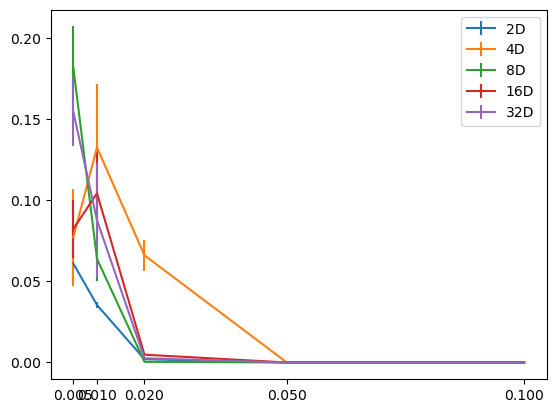

In [16]:
# method = 'lrt_permuation'
# method = 'lrt_bootstrap'
# method = 'auc_permuation'
# method = 'auc_bootstrap'
method = 'mce_permuation'
# method = 'mce_bootstrap'
for i in range(len(output_dim)):
    plt.errorbar(test_lambdas, file[method+'_p_value_mean'][i], yerr=file[method+'_p_value_std'][i], label=str(output_dim[i])+"D")
plt.xticks(test_lambdas)
plt.legend()
plt.show()

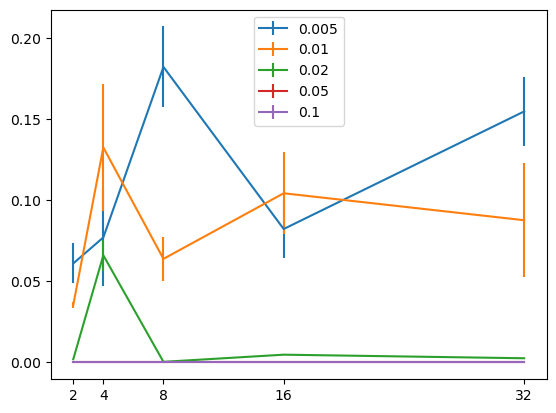

In [17]:
for i in range(len(test_lambdas)):
    plt.errorbar(output_dim, file[method+'_p_value_mean'][:,i], yerr=file[method+'_p_value_std'][:,i], label=str(test_lambdas[i]))
plt.xticks(output_dim)
plt.legend()
plt.show()

In [18]:
test_signal = "charged_Higgs"
# test_signal = "neutral_Higgs"
# test_signal = "leptoquark"
# test_signal = "neutral_boson"
output_dim = [2,4,8,16,32]
test_lambdas = [0.005, 0.01, 0.02, 0.05, 0.1]
file = np.load('../paper/Kuusela_'+test_signal+'_'+p_value_method+'.npz')
methods = ['lrt_permuation','lrt_bootstrap','auc_permuation','auc_bootstrap','mce_permuation','mce_bootstrap']
p_value_means = np.zeros((len(methods), len(output_dim), len(test_lambdas)))
p_value_stds = np.zeros((len(methods), len(output_dim), len(test_lambdas)))
for i, method in enumerate(methods):
        p_value_means[i] = file[method+'_p_value_mean']
        p_value_stds[i] = file[method+'_p_value_std']
average_p_value_mean = np.mean(p_value_means, axis=0)
average_p_value_std = np.mean(p_value_stds, axis=0)

In [21]:
print(average_p_value_mean)

[[1.51626276e-001 1.05567723e-001 9.04424160e-004 1.34488880e-029
  8.72213248e-123]
 [            nan 4.95932414e-002 5.53709163e-004 5.33167245e-043
  3.00878989e-130]
 [            nan 8.68210992e-003 1.14236478e-004 3.62550942e-048
  6.68162806e-124]
 [            nan             nan 2.05406053e-005 1.85533870e-019
  4.96794440e-129]
 [            nan 1.25973122e-002 1.64802177e-003 2.22626815e-030
  2.10514877e-122]]


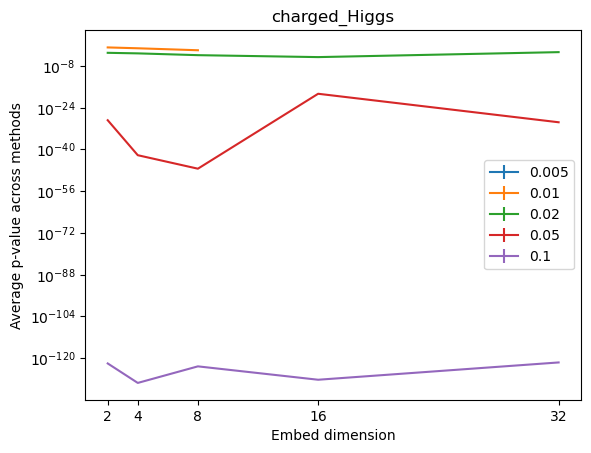

In [22]:
for i in range(len(test_lambdas)):
    plt.errorbar(output_dim, average_p_value_mean[:,i], yerr=average_p_value_std[:,i], label=str(test_lambdas[i]))
plt.xticks(output_dim)
plt.ylabel("Average p-value across methods")
plt.xlabel("Embed dimension")
plt.title(test_signal)
plt.yscale('log')
plt.legend()
plt.show()

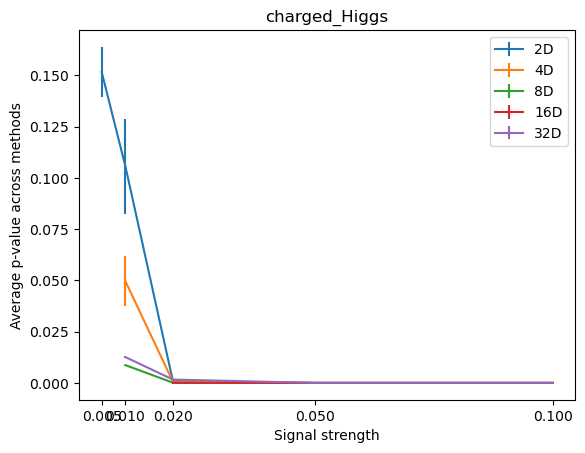

In [20]:
for i in range(len(output_dim)):
    plt.errorbar(test_lambdas, average_p_value_mean[i], yerr=average_p_value_std[i], label=str(output_dim[i])+"D")
plt.xticks(test_lambdas)
plt.ylabel("Average p-value across methods")
plt.xlabel("Signal strength")
plt.title(test_signal)
plt.legend()
plt.show()